This tutorial is adapted from the official Detectron2 Colab tutorial: https://colab.research.google.com/drive/16jcaJoc6bCFAQ96jDe2HwtXj7BMD_-m5

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random

import os 

In [2]:
models = [
    "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml",
    "COCO-Detection/retinanet_R_50_FPN_3x.yaml",
    "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml",
]

In [3]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog, MetadataCatalog

base_path = '../data'
for subset in ['train', 'val', 'test']:
    
    json_annotation = f'{base_path}/annotations/main_{subset}.json'
    image_path_base = f'{base_path}/{subset}'
    register_coco_instances(f"HJDataset_{subset}", {}, json_annotation, image_path_base)

# Train Layout Detection Model based on Mask RCNN

In [4]:
model_idx = 0

In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [6]:
model_name = models[model_idx]
output_path = os.path.join('./train_log', os.path.basename(model_name.split('.')[0]))
    # You may need to create the train_log folder first 
    
if not os.path.exists(output_path):
    os.mkdir(output_path)

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(models[model_idx]))
cfg.OUTPUT_DIR = output_path

cfg.DATASETS.TRAIN = ("HJDataset_train",)
cfg.DATASETS.TEST = ("HJDataset_test",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(models[model_idx]) 
    # Or you can load our pretrained model 
    
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025  
cfg.SOLVER.MAX_ITER = 60000   
cfg.SOLVER.CHECKPOINT_PERIOD = 30000

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256  
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # 7 + 1 background dummy class 

with open(os.path.join(cfg.OUTPUT_DIR, 'config.yml'), 'w') as file:
    cfg.dump(stream=file)

In [ ]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

# Evaluation on the test set

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

evaluator = COCOEvaluator("HJDataset_test", cfg, False, output_dir=cfg.OUTPUT_DIR)
val_loader = build_detection_test_loader(cfg, "HJDataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

# Random Visualization 

In [10]:
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   
    # set the testing threshold for this model
cfg.TEST.DETECTIONS_PER_IMAGE = 200 
    # We may need to increase the detection numbers as we have 
    # many elements per page 

cfg.DATASETS.TEST = ("HJDataset_test", )
predictor = DefaultPredictor(cfg)

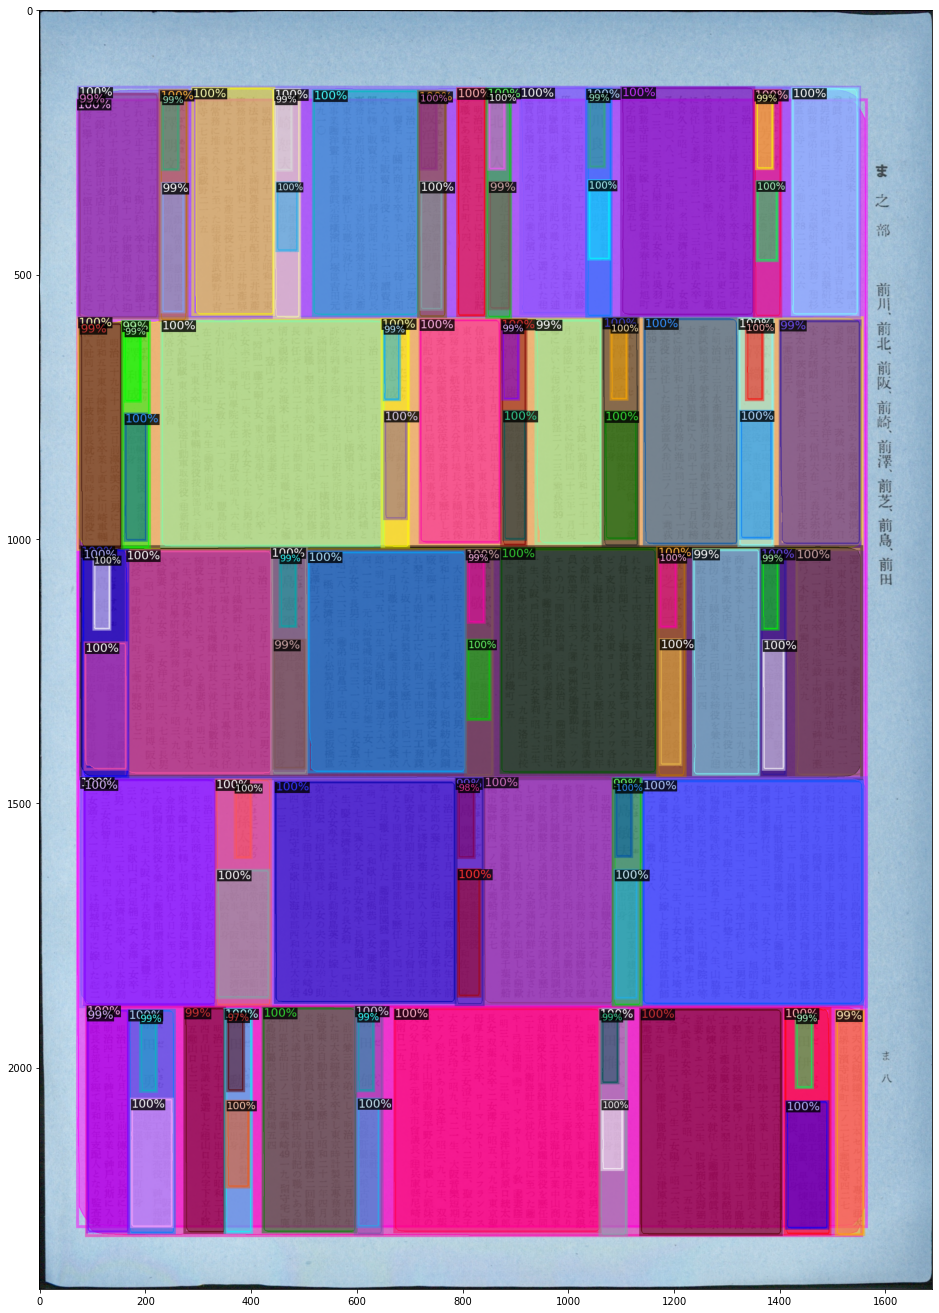

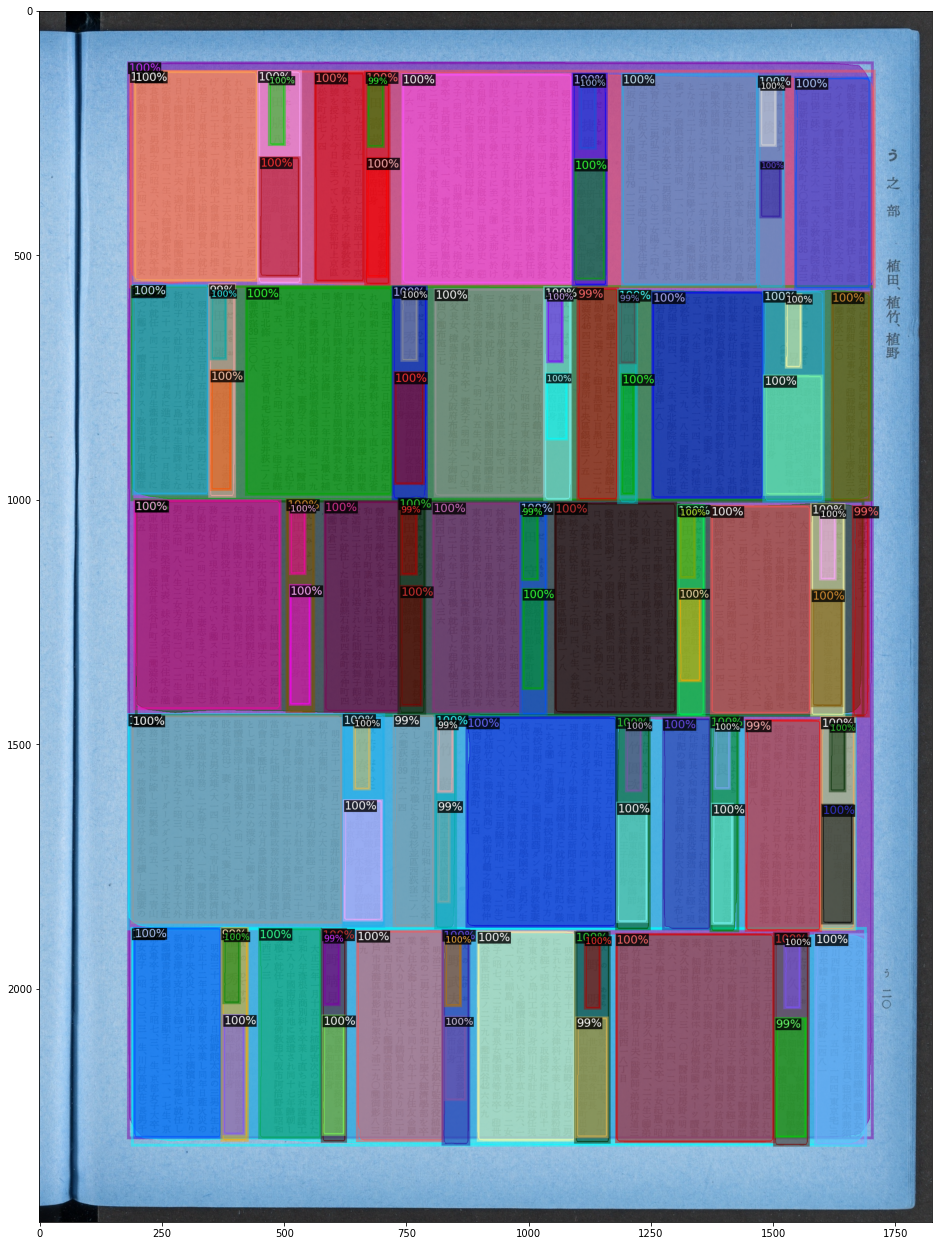

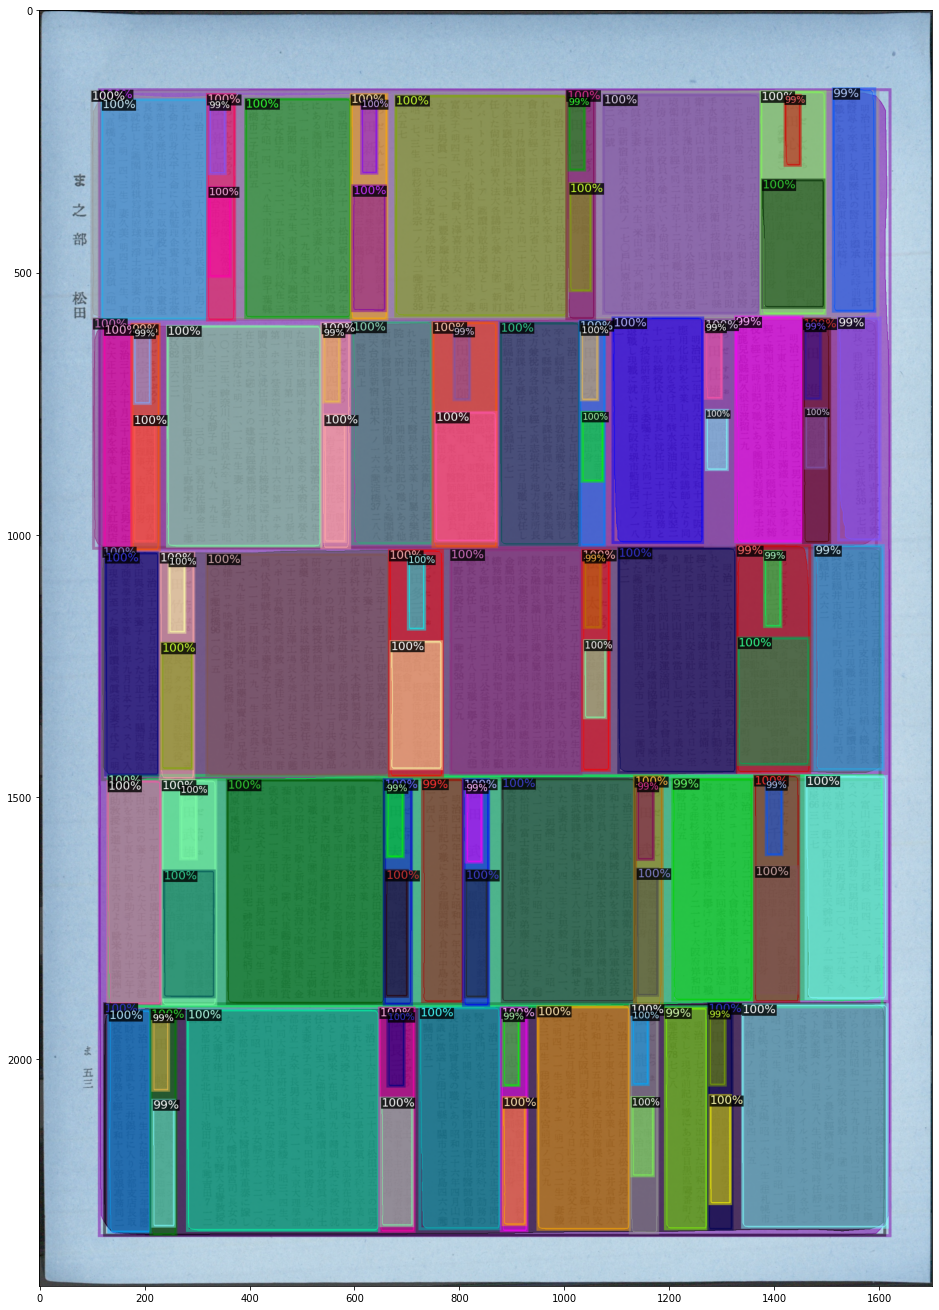

In [15]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(glob(f'{base_path}/test/*.jpg'), 3):    
    im = cv2.imread(d)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=MetadataCatalog.get("HJDataset_val"), 
                   scale=0.8, 
                   #instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize=(16,24))
    plt.imshow(v.get_image()[:, :, ::-1])
    plt.show()